# 支持向量机

In [1]:
# 初始参数

# 最大迭代次数
max_iter=100
# 核函数
kernel='linear'

max_iter = max_iter
_kernel = kernel

In [ ]:
def init_args(features, labels):
    m, n = features.shape
    X = features
    Y = labels
    b = 0.0

    # 将Ei保存在一个列表里
    self.alpha = np.ones(self.m)
    self.E = [self._E(i) for i in range(self.m)]
    # 松弛变量
    self.C = 1.0

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i, -1] == 0:
            data[i, -1] = -1
    # print(data)
    return data[:, :2], data[:, -1]

In [5]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

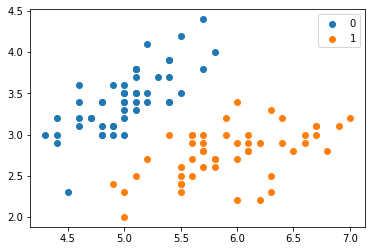

In [6]:
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [7]:
class SVM:
    def __init__(self, max_iter=100, kernel='linear'):
        self.max_iter = max_iter
        self._kernel = kernel

    def init_args(self, features, labels):
        self.m, self.n = features.shape
        self.X = features
        self.Y = labels
        self.b = 0.0

        # 将Ei保存在一个列表里
        self.alpha = np.ones(self.m)
        self.E = [self._E(i) for i in range(self.m)]
        # 松弛变量
        self.C = 1.0

    def _KKT(self, i):
        y_g = self._g(i) * self.Y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1

    # g(x)预测值，输入xi（X[i]）
    def _g(self, i):
        r = self.b
        for j in range(self.m):
            r += self.alpha[j] * self.Y[j] * self.kernel(self.X[i], self.X[j])
        return r

    # 核函数
    def kernel(self, x1, x2):
        if self._kernel == 'linear':
            return sum([x1[k] * x2[k] for k in range(self.n)])
        elif self._kernel == 'poly':
            return (sum([x1[k] * x2[k] for k in range(self.n)]) + 1)**2

        return 0

    # E（x）为g(x)对输入x的预测值和y的差
    def _E(self, i):
        return self._g(i) - self.Y[i]

    def _init_alpha(self):
        # 外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C]
        # 否则遍历整个训练集
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]
        index_list.extend(non_satisfy_list)

        for i in index_list:
            if self._KKT(i):
                continue

            E1 = self.E[i]
            # 如果E2是+，选择最小的；如果E2是负的，选择最大的
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j

    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha

    def fit(self, features, labels):
        self.init_args(features, labels)

        for t in range(self.max_iter):
            # train
            i1, i2 = self._init_alpha()

            # 边界
            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
                H = min(self.C, self.alpha[i1] + self.alpha[i2])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])

            E1 = self.E[i1]
            E2 = self.E[i2]
            # eta=K11+K22-2K12
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(
                self.X[i2],
                self.X[i2]) - 2 * self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                # print('eta <= 0')
                continue

            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (
                E1 - E2) / eta  #此处有修改，根据书上应该是E1 - E2，书上130-131页
            alpha2_new = self._compare(alpha2_new_unc, L, H)

            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (
                self.alpha[i2] - alpha2_new)

            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i1]) * (alpha2_new - self.alpha[i2]) + self.b
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i2]) * (alpha2_new - self.alpha[i2]) + self.b

            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2

            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new

            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
        return 'train done!'

    def predict(self, data):
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])

        return 1 if r > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            result = self.predict(X_test[i])
            if result == y_test[i]:
                right_count += 1
        return right_count / len(X_test)

    def _weight(self):
        # linear model
        yx = self.Y.reshape(-1, 1) * self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [8]:
svm = SVM(max_iter=200)

svm.fit(X_train, y_train)

svm.score(X_test, y_test)

0.52